In [1]:
#Import all nescesary modules

import pandas as pd
import seaborn as sns
from ema_workbench import save_results, load_results
import functools
from ema_workbench.analysis import parcoords
from ema_workbench.em_framework import sample_uncertainties
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import ema_logging, MultiprocessingEvaluator
import matplotlib.pyplot as plt

import numpy as np
from ema_workbench import Policy
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)
from ema_workbench import (MultiprocessingEvaluator, ema_logging, 
                           perform_experiments, SequentialEvaluator)
from ema_workbench.em_framework.optimization import (HyperVolume, 
                                                     EpsilonProgress)
from ema_workbench.em_framework.evaluators import BaseEvaluator

# Set the standard figure size
plt.rcParams['figure.figsize'] = (20, 10)

# 1. Problem Formulation

In [2]:
#Get problem formulation 3 for the dike_model

dike_model, planning_steps = get_model_for_problem_formulation(3)

In [3]:
# Load the data

results = load_results(r'./results/10000_experiments_MORDM.tar.gz')
experiments, outcomes = results

In [4]:
# Convert the outcomes to a dataframe

data = pd.DataFrame({k:v for k,v in outcomes.items()})

# Worst case Total Costs scenario

In [5]:
# Select the case with the highest total costs for Deventer

ooi = data.nlargest(1, ['A.5 Total Costs'])
ooidf = pd.DataFrame(ooi)
id_ooi = ooidf.index
ooidf

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
9107,1.135438e+08,0.060829,1.455280e+07,0.010785,8.629114e+07,0.118093,7.397656e+07,0.026362,1.518156e+09,0.958667,0.0,0.0


In [6]:
# Collect the corresponding experiment values

case = experiments.loc[id_ooi,['A.0_ID flood wave shape',
'A.1_Bmax',
'A.1_pfail',
'A.1_Brate',
'A.2_Bmax',
'A.2_pfail',
'A.2_Brate',
'A.3_Bmax',
'A.3_pfail',
'A.3_Brate',
'A.4_Bmax',
'A.4_pfail',
'A.4_Brate',
'A.5_Bmax',
'A.5_pfail',
'A.5_Brate']]

# 2. Identifying candidate solutions

In [8]:
# Create a scenario instance from the case selected above

from ema_workbench import Scenario
scenarios = [Scenario(f"{index}", **row) for index, row in case.iterrows()]

In [9]:
# Check the scenario

scenarios

[Scenario({'A.0_ID flood wave shape': 18.0, 'A.1_Bmax': 246.12808009415787, 'A.1_pfail': 0.6209912508834388, 'A.1_Brate': 10.0, 'A.2_Bmax': 90.89700535724546, 'A.2_pfail': 0.8580004025588307, 'A.2_Brate': 1.5, 'A.3_Bmax': 344.9175072245114, 'A.3_pfail': 0.8339688640656018, 'A.3_Brate': 1.5, 'A.4_Bmax': 176.29360625650756, 'A.4_pfail': 0.4089850654723588, 'A.4_Brate': 1.0, 'A.5_Bmax': 127.71047696310946, 'A.5_pfail': 0.0038245204955661, 'A.5_Brate': 10.0})]

In [33]:
# Optimize the model and save the data with the defined nfe and epsilon values
# Note: When trying to manually assign the performance metrics, the model didn't run. Therefore, all performance metrics
# from problem formulation 3 will be used as performance metrics in the optimization. The Total costs and expected deaths for 
# locations A1 to A4 have the same epsilon values as those from A5.

def optimize(scenario, nfe, model, converge_metrics, epsilons):


    with MultiprocessingEvaluator(model) as evaluator:
        results, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                     convergence=convergence_metrics,
                                     epsilons=epsilons,
                                     reference=scenario)
        results.to_csv('./results/MORDMresults_tc30k.csv', index=False)
        convergence.to_csv('./results/MORDMconvergence_tc30k.csv', index=False)
    return results, convergence


merged = []

for scenario in scenarios:
    convergence_metrics = [EpsilonProgress()]
    epsilons = [100000,0.1,100000,0.1,100000,0.1,100000,0.1,100000,0.1,100000,1000]
    
    merged.append(optimize(scenario, 30000, dike_model, convergence_metrics, epsilons))

32210it [4:01:05,  2.23it/s]                                                   


In [15]:
# Read the saved results

df_tc = pd.read_csv('./results/MORDMresults_tc30k.csv')
df_tc_c = pd.read_csv('./results/MORDMconvergence_tc30k.csv')

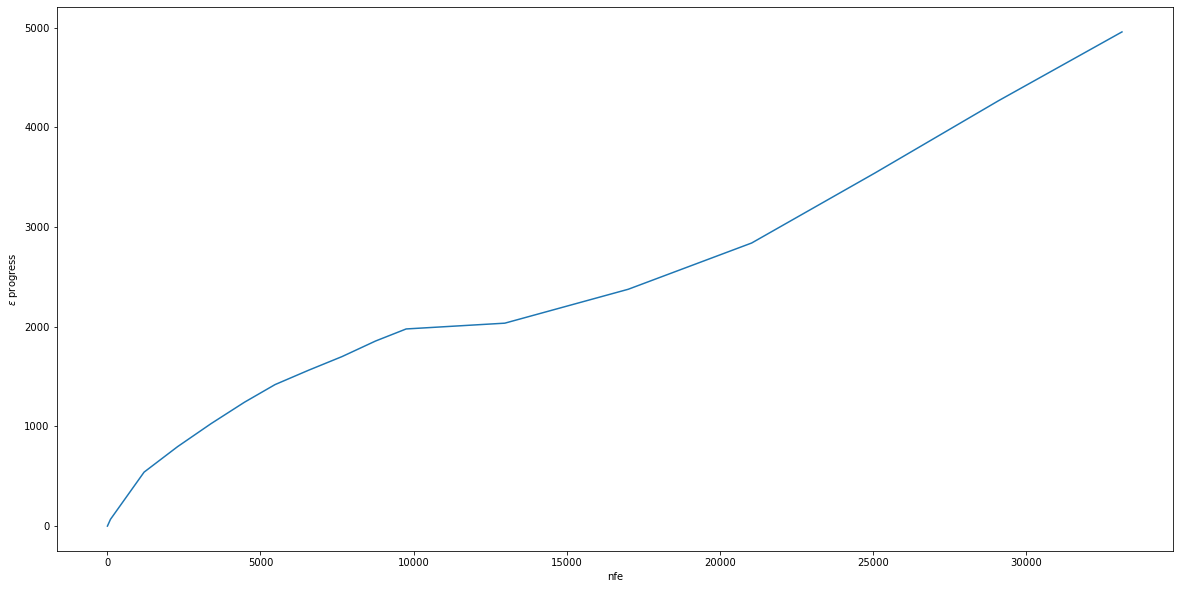

In [16]:
# Check the epsilon progress

fig, ax = plt.subplots()

ax.plot(df_tc_c['nfe'], df_tc_c['epsilon_progress'])

ax.set_ylabel('$\epsilon$ progress')
ax.set_xlabel('nfe')
plt.show()

### 3 Re-evaluating candidate solutions
For the worst case total costs for Deventer scenario as reference scenario. The expected number of deaths constraint will be set to 0.01. To further filter the candidate solutions, the constraint for the total costs for Deventer will be set to 80.000.000. These set of constraints leave 21 candidate solutions that will be re-evaluated.

In [17]:
# Apply the constrains

filtered_tc = (df_tc['A.5_Expected Number of Deaths'] < 0.01) & (df_tc['A.5 Total Costs'] < 8e7) 
np.sum(filtered_tc)

21

In [18]:
# Retrieve the experiments associated with the filtered policies

policies_tc = df_tc[filtered_tc]
policies_tc = policies_tc.drop([o.name for o in dike_model.outcomes], axis=1)
policies_tc.head()

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
154,0,0,1,1,0,0,0,0,0,0,...,3,0,0,1,0,0,2,7,0,0
293,0,0,1,1,0,0,0,1,1,1,...,3,0,0,1,0,0,1,7,0,0
302,0,0,0,1,0,0,1,0,1,0,...,1,0,2,3,9,1,3,9,0,0
303,0,0,1,1,0,1,1,1,0,1,...,9,1,2,1,10,10,4,8,0,0
323,0,1,0,0,0,0,1,0,1,1,...,0,3,5,0,2,0,3,10,0,0


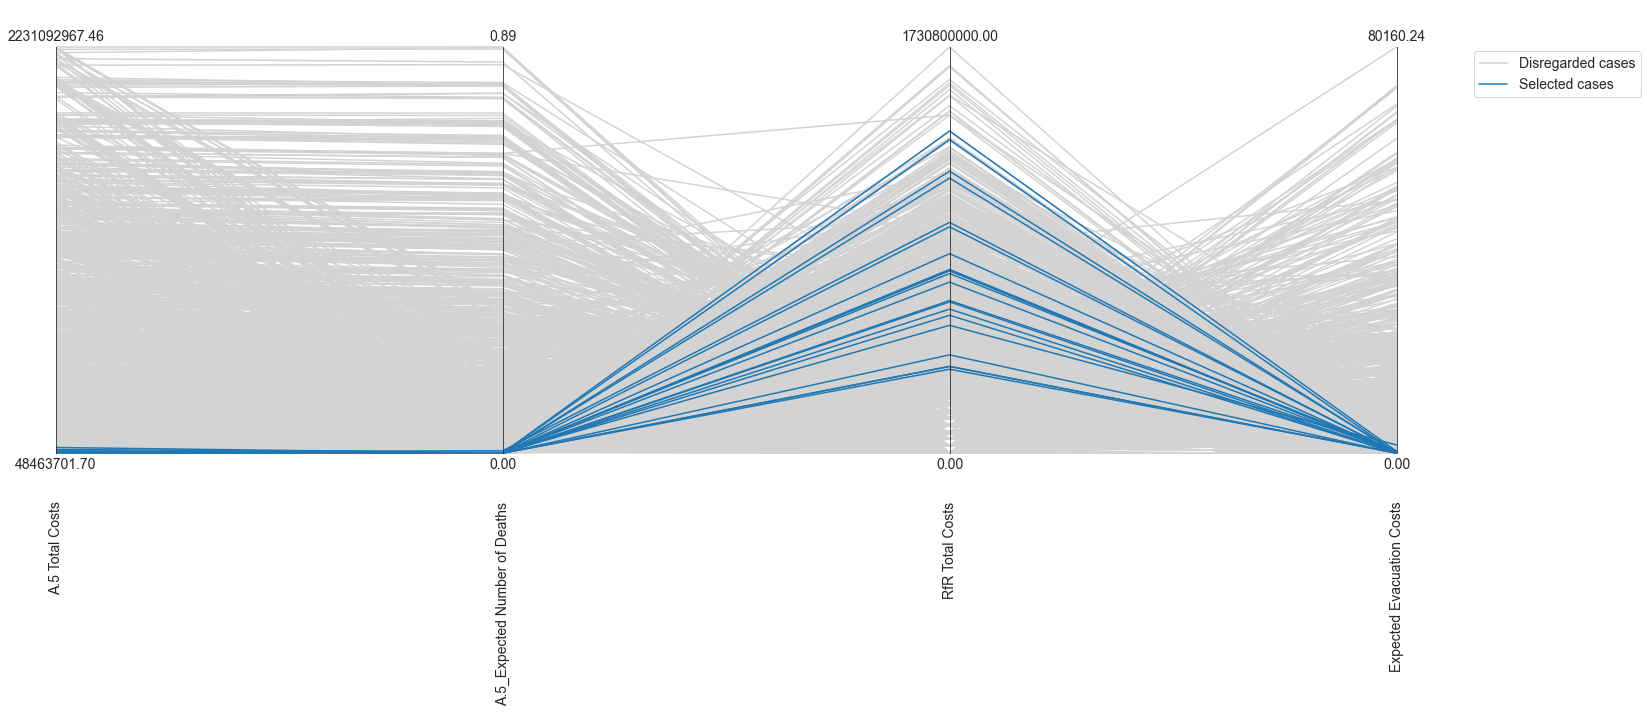

In [19]:
# Create a parcoord from the outcomes and highlight the filtered cases

dfA5outcomes_tc = df_tc[['A.5 Total Costs','A.5_Expected Number of Deaths',
                      'RfR Total Costs','Expected Evacuation Costs']]
limits = parcoords.get_limits(dfA5outcomes_tc)
selected_tc = df_tc[filtered_tc]

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(dfA5outcomes_tc, color='lightgrey', label='Disregarded cases')
paraxes.plot(selected_tc, color='tab:blue', label='Selected cases')

paraxes.legend()
plt.show()

In [20]:
# Add the filtered policies to a policy instance

from ema_workbench import Policy

policies_tc_eval = []

for i, policy in policies_tc.iterrows():
    policies_tc_eval.append(Policy(str(i), **policy.to_dict()))

In [ ]:
# Run the evaluator with 1000 experiments per policy

ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(dike_model) as evaluator:
     reeevaluation_results_tc = evaluator.perform_experiments(1000, policies=policies_tc_eval)

save_results(reeevaluation_results_tc, './results/reeevaluation_results_tc.tar.gz')

[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] performing 1000 scenarios * 21 policies * 1 model(s) = 21000 experiments
 26%|█████████                          | 5431/21000 [39:05<1:17:06,  3.37it/s]

# 3. Uncertainty analysis

### 3.1 Signal-to-noise ratio

In [51]:
# Load the re-evaluation results

reeevaluation_results_tc = load_results(r'./results/reeevaluation_results_tc.tar.gz')
experiments, outcomes = reeevaluation_results_tc

In [52]:
# define the signal-to-noise function

def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    return mean*std

In [53]:
overall_scores = {}

# iterate over the unique policies
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy

    # calculate the signal-to-noise ratio for all outcomes
    for outcome in dike_model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
    
# create a dataframe from the dictionary with the scores and filter only the relevant performance metrics
scores = pd.DataFrame.from_dict(overall_scores).T
scores = scores[['A.5 Total Costs', 'A.5_Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs']]

In [54]:
scores

,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
154,1.835211e+14,1.296314e-08,0.0,5.247730e+08
293,1.248987e+14,2.806999e-07,0.0,0.000000e+00
302,1.417105e+14,3.822061e-09,0.0,2.763417e+07
303,1.095294e+14,2.284064e-08,0.0,1.872251e+06
323,5.072910e+13,2.821701e-09,0.0,9.938839e+05
443,1.471553e+14,3.994346e-08,0.0,9.191129e+02
461,2.307760e+14,6.786870e-07,0.0,0.000000e+00
496,1.300349e+00,0.000000e+00,0.0,2.750680e+07
633,1.708325e+14,9.428698e-09,0.0,3.079252e+07
670,3.212325e+13,6.714375e-09,0.0,0.000000e+00


In [55]:
# Check the policy with the lowest signal-to-noise ratio for the expected deaths

scores[['A.5_Expected Number of Deaths']].idxmin()

A.5_Expected Number of Deaths    496
dtype: int64

In [89]:
# Check the 5 policies with the lowest signal-to-noise ratio for the expected deaths

scores.nsmallest(columns='A.5_Expected Number of Deaths', n=5)

,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
496,1.300349e+00,0.000000e+00,0.0,2.750680e+07
1564,1.961703e+13,1.993295e-11,0.0,1.212730e+08
1286,5.627681e+13,3.085728e-10,0.0,5.319047e+07
1795,5.425571e+13,5.175267e-10,0.0,7.397936e+07
323,5.072910e+13,2.821701e-09,0.0,9.938839e+05


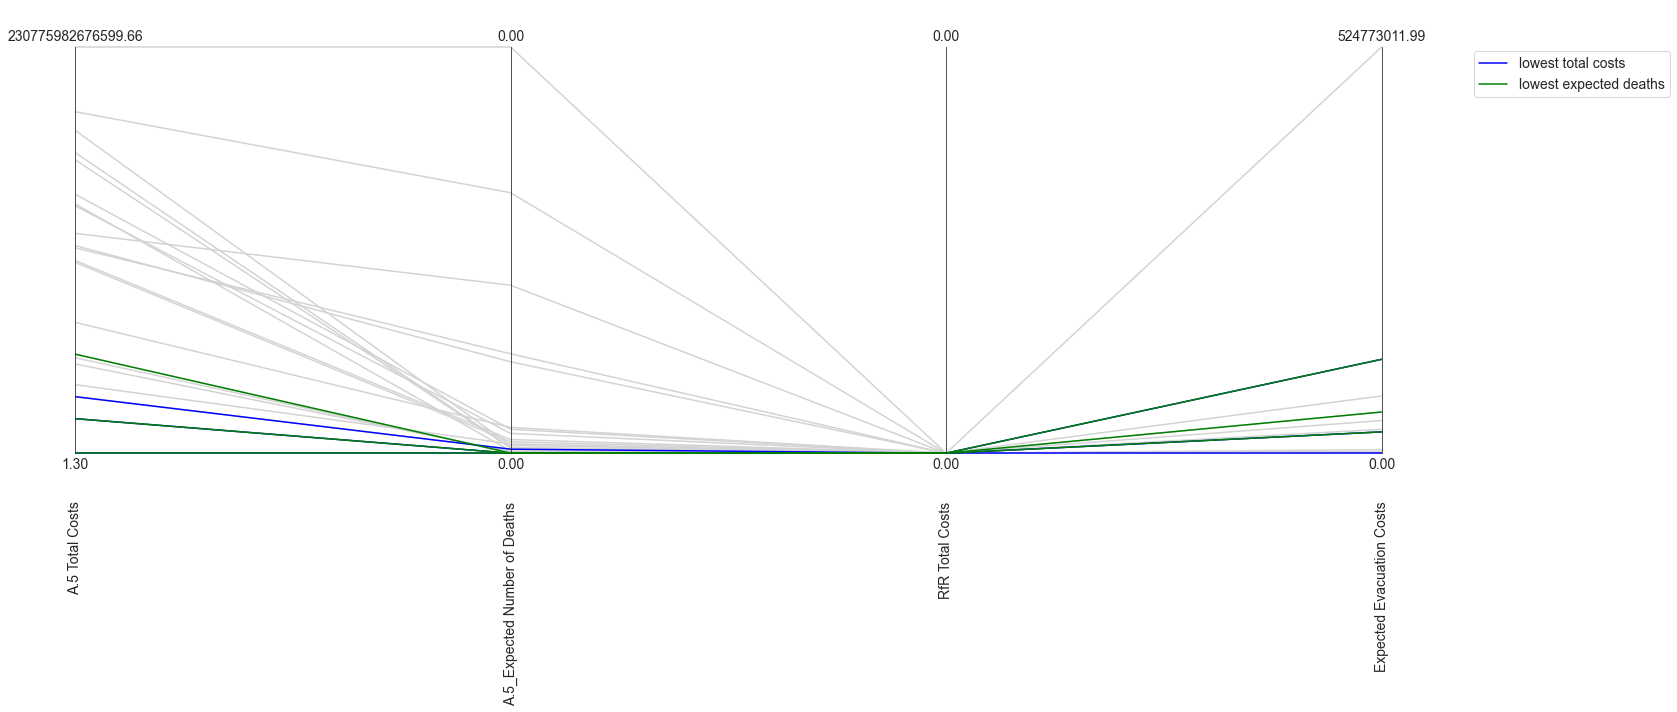

In [56]:
# create a parcoords with all policies and highlight the selected policies in 2 different colors

limits = parcoords.get_limits(scores)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(scores, color='lightgrey')
paraxes.plot(scores.nsmallest(columns='A.5 Total Costs', n=3), color='blue', label='lowest total costs')
paraxes.plot(scores.nsmallest(columns='A.5_Expected Number of Deaths', n=3), color='green', label='lowest expected deaths')

paraxes.legend()
plt.show()

### 3.2 Maximum regret

In [67]:
# Create a dataframe with one policy per row

for scenario in experiments.scenario.unique():
    logical = experiments.scenario==scenario
    temp_results = {k:v[logical] for k,v in outcomes.items()}
    temp_results = pd.DataFrame(temp_results)

In [29]:
temp_results

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,1.019881e+08,0.000000,4.061944e+08,0.037703,4.084479e+08,0.087840,7.332080e+06,0.000000,4.419351e+07,0.0,5.448000e+08,26315.050300
1,1.094482e+08,0.000000,1.842988e+08,0.000000,7.315464e+07,0.085193,6.567259e+06,0.000182,4.419351e+07,0.0,9.835000e+08,0.000000
2,2.849619e+08,0.000000,2.289068e+08,0.000000,7.996866e+07,0.006115,3.852595e+07,0.000000,5.311400e+07,0.0,7.777000e+08,1363.150991
3,1.548348e+08,0.000000,1.871699e+08,0.000000,7.654761e+07,0.006680,6.789358e+07,0.000000,4.846370e+07,0.0,1.201300e+09,233.828422
4,1.284266e+08,0.000000,1.338442e+08,0.000000,5.701237e+07,0.000603,1.670515e+07,0.000055,5.817663e+07,0.0,6.445000e+08,29.298362
5,1.648373e+08,0.000000,2.254547e+08,0.000000,1.349425e+08,0.000000,3.230495e+07,0.000000,5.311400e+07,0.0,4.191000e+08,0.000000
6,2.544214e+08,0.000000,2.426661e+08,0.000000,6.662956e+07,0.000000,4.026364e+07,0.000000,5.817663e+07,0.0,5.875000e+08,0.000000
7,8.526436e+07,0.000000,3.918488e+08,0.121042,1.005660e+08,0.000000,1.544456e+07,0.000000,5.817663e+07,0.0,1.172300e+09,10631.740401
8,6.813900e+07,0.000000,3.161568e+08,0.000000,6.644345e+07,0.003960,2.422758e+07,0.000000,4.419351e+07,0.0,1.372800e+09,910.579493
9,1.814302e+08,0.000000,2.555280e+08,0.125376,2.482618e+07,0.001675,1.106877e+07,0.000000,5.817663e+07,0.0,7.291000e+08,0.000000


In [68]:
# calculate and create 4 regret columns and filter the dataframe to only the regret columns

temp_results['regret_deaths'] = temp_results['A.5_Expected Number of Deaths']-temp_results['A.5_Expected Number of Deaths'].min()
temp_results['regret_A5costs'] = temp_results['A.5 Total Costs']-temp_results['A.5 Total Costs'].min()
temp_results['regret_RfRcosts'] = temp_results['RfR Total Costs']-temp_results['RfR Total Costs'].min()
temp_results['regret_evacuation_costs'] = temp_results['Expected Evacuation Costs']-temp_results['Expected Evacuation Costs'].min()
regret = temp_results[['regret_deaths', 'regret_A5costs','regret_RfRcosts','regret_evacuation_costs']]

In [69]:
regret

,regret_deaths,regret_A5costs,regret_RfRcosts,regret_evacuation_costs
0,0.0,0.000000e+00,1.871000e+08,26315.050300
1,0.0,0.000000e+00,6.258000e+08,0.000000
2,0.0,8.920489e+06,4.200000e+08,1363.150991
3,0.0,4.270188e+06,8.436000e+08,233.828422
4,0.0,1.398311e+07,2.868000e+08,29.298362
5,0.0,8.920489e+06,6.140000e+07,0.000000
6,0.0,1.398311e+07,2.298000e+08,0.000000
7,0.0,1.398311e+07,8.146000e+08,10631.740401
8,0.0,0.000000e+00,1.015100e+09,910.579493
9,0.0,1.398311e+07,3.714000e+08,0.000000


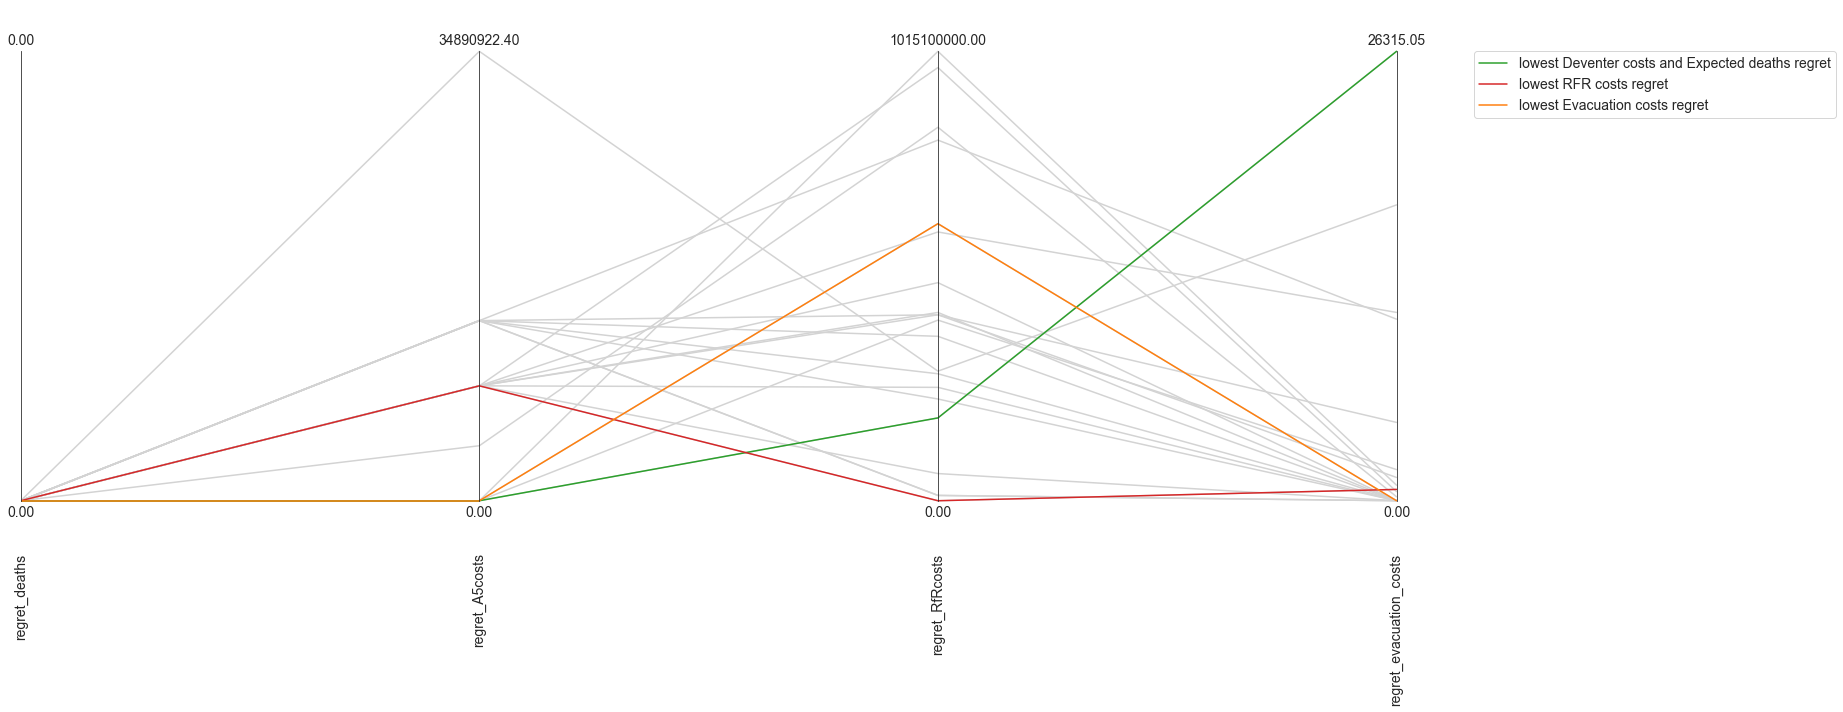

In [39]:
# Create a parcoords and highlight the selected cases in different colors

limits = parcoords.get_limits(regret)

paraxes = parcoords.ParallelAxes(limits)
# deaths and costs are the same line
paraxes.plot(regret, color = 'lightgrey')
#paraxes.plot(regret.nsmallest(columns='regret_deaths', n=1), color='tab:blue', label='lowest Expected deaths regret')
paraxes.plot(regret.nsmallest(columns='regret_A5costs', n=1), color='tab:green', label='lowest Deventer costs and Expected deaths regret')
paraxes.plot(regret.nsmallest(columns='regret_RfRcosts', n=1), color='tab:red', label='lowest RFR costs regret')
paraxes.plot(regret.nsmallest(columns='regret_evacuation_costs', n=1), color='tab:orange', label='lowest Evacuation costs regret')

paraxes.legend()
plt.show()

In [87]:
# Show the cases sorted by the lowest Deventer total costs regret

regret.nsmallest(columns='regret_A5costs', n=21)

,regret_deaths,regret_A5costs,regret_RfRcosts,regret_evacuation_costs
0,0.0,0.000000e+00,1.871000e+08,26315.050300
1,0.0,0.000000e+00,6.258000e+08,0.000000
14,0.0,0.000000e+00,4.080000e+08,1824.057798
8,0.0,0.000000e+00,1.015100e+09,910.579493
3,0.0,4.270188e+06,8.436000e+08,233.828422
18,0.0,8.920489e+06,6.071000e+08,11026.658726
17,0.0,8.920489e+06,2.561000e+08,0.000000
15,0.0,8.920489e+06,4.926000e+08,0.000000
11,0.0,8.920489e+06,9.785000e+08,535.899169
10,0.0,8.920489e+06,4.253000e+08,0.000000


In [103]:
# Get the experiment values for case 18000

experiments.iloc[18000, 19:53]

0_RfR 0                      0
0_RfR 1                      0
0_RfR 2                      0
1_RfR 0                      0
1_RfR 1                      1
1_RfR 2                      1
2_RfR 0                      1
2_RfR 1                      0
2_RfR 2                      0
3_RfR 0                      1
3_RfR 1                      0
3_RfR 2                      1
4_RfR 0                      0
4_RfR 1                      1
4_RfR 2                      0
EWS_DaysToThreat             3
A.1_DikeIncrease 0           0
A.1_DikeIncrease 1           0
A.1_DikeIncrease 2           1
A.2_DikeIncrease 0           0
A.2_DikeIncrease 1           2
A.2_DikeIncrease 2           0
A.3_DikeIncrease 0           7
A.3_DikeIncrease 1           7
A.3_DikeIncrease 2           0
A.4_DikeIncrease 0           2
A.4_DikeIncrease 1           0
A.4_DikeIncrease 2           3
A.5_DikeIncrease 0           9
A.5_DikeIncrease 1           0
A.5_DikeIncrease 2           0
scenario                  1000
policy  

In [104]:
# Create a dataframe with the outcome values of the policy of interest
# This policy is in the top 3 lowest maximum regret and in the top 6
# of the signal-to-noise ratio for the expected deaths. The only policy
# that scores high in both metrics.

x = pd.DataFrame.from_dict(outcomes)
policy_interest = x.loc[18000:18999, :]
policy_interest = policy_interest[['A.5 Total Costs', 'A.5_Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs']]

In [105]:
# show the mean value per performance metric of all 1000 scenarios for the policy of interest

policy_interest.mean()

A.5 Total Costs                  5.316924e+07
A.5_Expected Number of Deaths    5.266887e-06
RfR Total Costs                  9.648000e+08
Expected Evacuation Costs        6.542265e+03
dtype: float64

# 4 Scenario Discovery

In [40]:
from ema_workbench.analysis import prim

In [41]:
# set the experiment values as x and the outcomes of Expected number of deaths for Deventer as y with a threshold 
# of 0.000001

x = experiments.iloc[:, 0:20]
y_deaths = outcomes['A.5_Expected Number of Deaths'] < 0.000001

In [42]:
# run the prim with the defined x and y

prim_alg = prim.Prim(x, y_deaths, threshold=0.8, peel_alpha=0.01)
box1 = prim_alg.find_box()

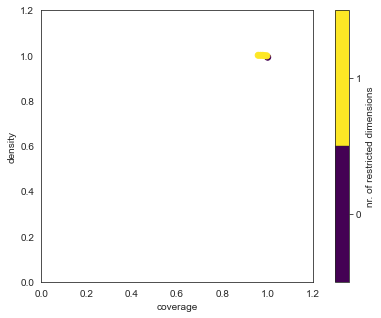

In [43]:
# show the tradeoff figure

fig = box1.show_tradeoff()

fig.set_size_inches(8,5)
plt.show()

coverage    0.978148
density     0.999853
id                 3
mass            0.97
mean        0.999853
res_dim            1
Name: 3, dtype: object

              box 3                                         
                min       max                      qp values
A.5_pfail  0.030189  0.999685  [4.436772889775073e-70, -1.0]



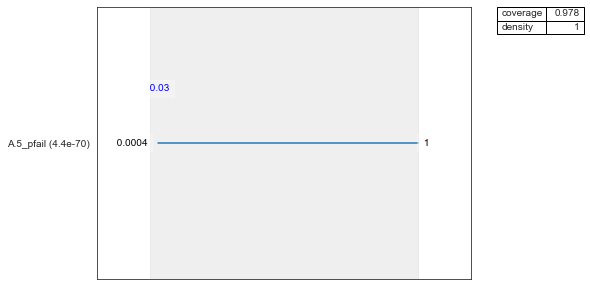

In [50]:
# inspect the box with the highest density and at least 0.8 coverage

box1.inspect(3)
fig = box1.inspect(3, style='graph')

fig.set_size_inches(8,5)
#plt.savefig('summed_box_deaths.png', bbox_inches = 'tight')
plt.show()